In [31]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import itertools

In [3]:
reviews = pd.read_sql(f"""
    SELECT podcast_id, author_id, rating, reviews.created_at , reviews.title, reviews.content 
    FROM reviews
    Where rating > 3
""", sqlite3.connect("../database.sqlite"))

podcast_w_category = pd.read_sql(f"""
    SELECT podcast_id, title as p_title, category
    FROM categories JOIN podcasts USING (podcast_id)
""", sqlite3.connect("../database.sqlite"))

In [4]:
# for each podcast, concatenate all categories once you sort them
podcast_w_category = podcast_w_category.groupby("podcast_id").agg({"p_title": "first", "category": lambda x: "#".join(sorted(x))}).reset_index()
# sort by aurhor_id, podcast_id and created_at
reviews = reviews.sort_values(by=['author_id', 'podcast_id', 'created_at'])

# check if there are any duplicates
duplicates = reviews.duplicated(subset=['author_id','podcast_id'], keep='last')
total_duplicates = duplicates.shape[0] - (duplicates.shape[0] - duplicates.sum())

# remove based on boolean mask
reviews = reviews[~duplicates]
print(f'Removed {total_duplicates} duplicates ~ {round(duplicates.sum()/duplicates.shape[0],3)}% of total reviews')

# get all podcast ids in podcast_w_category
pod_id_in_table = podcast_w_category['podcast_id'].unique()
# remove all author ids that are in reviews but not in podcast_w_category
before = reviews.shape[0]
reviews = reviews[reviews['podcast_id'].isin(pod_id_in_table)]
after = reviews.shape[0]
print(f'Removed {before - after} reviews ~ {round((before - after)/before,3)}% of total reviews')

# Keep only authors with at least K reviews
K = 5
reviews = reviews.groupby('author_id').filter(lambda x: len(x) >= K)


# print unique authors and reviews
print(f'Unique authors: {reviews["author_id"].unique().shape[0]}')
print(f'Unique reviews: {reviews.shape[0]}')

# merge reviews with podcast_w_category
reviews_w_podcast_w_category = reviews.merge(podcast_w_category, on='podcast_id', how='inner')
# keep only the columns we need
reviews_w_podcast_w_category = reviews_w_podcast_w_category[['author_id', 'podcast_id', 'p_title', 'category', 'rating', 'created_at']]
reviews_w_podcast_w_category = reviews_w_podcast_w_category.sort_values(by=['author_id', 'created_at'], ascending=False)
df = reviews_w_podcast_w_category.copy()

Removed 59619 duplicates ~ 0.033% of total reviews
Removed 21579 reviews ~ 0.012% of total reviews
Unique authors: 18551
Unique reviews: 156646


In [5]:
df

,author_id,podcast_id,p_title,category,rating,created_at
37962,FFF559CD2875885,f5f405721f37e3311a58f07da974c756,Pink Shade,comedy#tv-film#tv-film-tv-reviews,5,2022-04-27T05:12:10-07:00
70977,FFF559CD2875885,d90bfe6641533109ad8becc21057319e,True Crime & Cocktails,tv-film,5,2021-10-05T07:42:16-07:00
144040,FFF559CD2875885,accd597caede356b5b920ed044847925,Marriage and Murder,society-culture#society-culture-relationships#...,4,2020-04-08T10:57:50-07:00
13437,FFF559CD2875885,bf5bf76d5b6ffbf9a31bba4480383b7f,Crime Junkie,true-crime,5,2019-12-16T15:14:17-07:00
6264,FFF559CD2875885,b1a3eb2aa8e82ecbe9c91ed9a963c362,True Crime Obsessed,society-culture#true-crime,5,2019-12-09T05:09:17-07:00
...,...,...,...,...,...,...
9,000303F51BFEAE2,dba7c6e2009ea027364962462bf625fc,Smoke N Sip Podcast,music#music-music-commentary,5,2020-07-31T20:45:20-07:00
5,000303F51BFEAE2,d5b30c08df0f49c104e4b2d01cd9cb91,Millennial Relationships Unlocked Podcast,education#education-self-improvement#society-c...,5,2020-06-16T08:09:13-07:00
7,000303F51BFEAE2,d7ff8f8b0c86aafe0e3f81d281c20e10,"Pero, Who Am I?! podcast",society-culture#society-culture-personal-journ...,5,2020-06-16T07:51:41-07:00
0,000303F51BFEAE2,c6e2fbe83cb68f72f1424672616a0f61,Another Shot Podcast,society-culture#society-culture-relationships#...,5,2020-06-16T07:47:21-07:00


In [6]:
#We start by creating the baskets - which is essentially the positive reviews a user has given
baskets = [list(set(a[1]['p_title'].tolist())) for a in list(df.groupby('author_id'))]

In [7]:
### We can extract the unique items
items = set(list(np.concatenate(baskets).flat))
print(len(items))
print(len(baskets))

31651
18551


In [8]:
#Creating a hashed dataset for easy lookup
df_item_hash = pd.DataFrame(range(len(items)), index = list(items), columns =['hashcode'], dtype=int)
df_item_hash

,hashcode
MySportsUpdate Football Podcast,0
DATE YOUR WIFE,1
Inspiring Leaders: Leadership Stories with Impact,2
Tackling Life,3
Past Lives & the Divine,4
...,...
Life with Heart Podcast,31646
Airspeed,31647
Puss N' Heels,31648
The Stew Peters Show,31649


In [9]:
#Here we are creating an array to count how many different users have rated each podcast. We can then filter out the podcasts above a certain treshhold. We can see that treshhold support is set to 30. This is chosen by testing on different sizes.
item_count_arr = np.zeros((len(items),1))

for b in baskets:
    for item in b:
            idx = df_item_hash.loc[item,'hashcode']
            item_count_arr[idx] += 1
            
freq_items  = [df_item_hash[df_item_hash['hashcode']==x].index[0] for x in np.where(item_count_arr > 30)[0]] 
len(freq_items)

833

In [10]:
df_freq_item_hash = pd.DataFrame(range(1,len(freq_items)+1), index=freq_items, columns=['hashcode'])
df_freq_item_hash

,hashcode
Strange Matters Podcast,1
Work/Life Imbalance,2
Watching Westworld,3
James Bonding,4
Real Crime Profile,5
...,...
Deep into History,829
Your New Best Friends,830
Lore,831
Flipped Lifestyle Podcast,832


In [11]:
#Now we create a matrix to store the counts of pairs
pair_mat_hashed = np.zeros((len(freq_items)+1,len(freq_items)+1))

for b in baskets:
    cand_list = [item for item in b if item in freq_items]
    if len(cand_list)<2:
        continue
    for idx, item1 in enumerate(cand_list):
        for item2 in cand_list[idx+1:]:
            i = df_freq_item_hash.loc[item1,'hashcode'] 
            j = df_freq_item_hash.loc[item2,'hashcode'] 
            pair_mat_hashed[max(i,j),min(i,j)]+=1

In [12]:
freq_pairs = [[df_freq_item_hash[df_freq_item_hash['hashcode']==x].index[0], df_freq_item_hash[df_freq_item_hash['hashcode']==y].index[0]] for x, y in zip(*np.where(pair_mat_hashed > 30))]
temp_freq_items = [item for sublist in freq_pairs for item in sublist]
freq_items_from_pairs = set(temp_freq_items)
df_freq_item_hash = pd.DataFrame(range(1,len(freq_items_from_pairs)+1), index=freq_items_from_pairs, columns=['hashcode'])
df_freq_item_hash

,hashcode
Drink in the Movies,1
Better PR Now with Mark Phillips,2
Octane Personal Training with Jason Benavides,3
Me Being Crafty with Tsoniki Crazy Bull,4
The Kelly Roach Show,5
...,...
"THE STEFANIE GASS SHOW - Christian Entrepreneur, Start an Online Business, Work From Home, Get More...",146
Worldbuilder's Anvil,147
Leaders Inspire Leaders with Koy McDermott,148
Seasoned Athlete,149


In [13]:
#Finally we create a 3-dimensional matrix to store the counts of triplets
triplet_mat_hashed = np.zeros((len(freq_items_from_pairs)+1,len(freq_items_from_pairs)+1,len(freq_items_from_pairs)+1))

for b in baskets:
    cand_list = [item for item in b if item in freq_items_from_pairs]
    if len(cand_list)<3:
        continue
    for idx, item1 in enumerate(cand_list):
        for item2 in cand_list[idx+1:]:
            for item3 in cand_list[idx+2:]:
                i = df_freq_item_hash.loc[item1,'hashcode'] 
                j = df_freq_item_hash.loc[item2,'hashcode'] 
                k = df_freq_item_hash.loc[item3,'hashcode']

                max = sorted([i, j, k])[2]
                min = sorted([i, j, k])[0]
                mid = sorted([i, j, k])[1]
                triplet_mat_hashed[max,min,mid]+=1

freq_triplets = [[df_freq_item_hash[df_freq_item_hash['hashcode']==x].index[0], df_freq_item_hash[df_freq_item_hash['hashcode']==y].index[0], df_freq_item_hash[df_freq_item_hash['hashcode']==z].index[0]] for x, y, z in zip(*np.where(triplet_mat_hashed > 30))]
len(freq_triplets)
temp_freq = [item for sublist in freq_triplets for item in sublist]
freq_items_from_triplets = set(temp_freq)
unique_data = [list(x) for x in set(tuple(x) for x in freq_triplets)]

In [14]:
#We will now continue to create a graph by using the networkx package. We can model our list of triplets as nodes in a graph where the edges are the groups.
import networkx as nx
G = nx.Graph()
for items in unique_data:
    G.add_edge(items[0], items[1])
    G.add_edge(items[0], items[2])
    G.add_edge(items[1], items[2])

In [15]:
#This way we can use the special features of the nodes in a graph and look at common neighbors of two or more nodes to determine the list of recommendations. We will walk throgh a practical example
item_a = unique_data[4][0]
item_b = unique_data[4][1]
print(unique_data[4][2])

Mindfulness Mode


In [16]:
#We can in fact see that the third item in the triplet is in the list. We have more items here since a lot of the same items can be connected. 
sorted(nx.common_neighbors(G, item_a, item_b))

['2000 Books for Ambitious Entrepreneurs - Author Interviews and Book Summaries',
 '40+ Fitness Podcast',
 'ADHD reWired',
 'Best Real Estate Investing Advice Ever',
 'Better PR Now with Mark Phillips',
 'Blockchain Innovation: Interviewing The Brightest Minds In Blockchain',
 'Build Your Network',
 'Business Coaching With Join Up Dots - Online Business Success The Easy Way !',
 'COMCASTRO Podcast',
 'Choir Ninja, with Ryan Guth',
 'Confessions of a Terrible Husband with Nick Pavlidis',
 'Conscious Millionaire Show ~ Business Coaching and Mentoring 6 Days a Week',
 'Educators Lead with Jay Willis',
 'Entrepreneur Stories 4⃣ Inspiration',
 'Epic Education Radio: Family Travel Podcast',
 'Ever Better Podcast | Inspiring Stories | Motivating | Transition with Grace | Fulfillment | Wisdom',
 'Everyday MBA',
 'Expert Authority Effect™ Interviews Starring Mario Fachini | Author, Expert, Entrepreneurship Interv...',
 'Fearless And Healthy Podcast',
 'Fit 2 Love',
 'Five Minutes With Dad with 

In [17]:
from fa2 import ForceAtlas2

In [18]:
#We can visualise the graph as following
degrees = []
for podcast in G.degree:
    degrees.append(podcast[1])

In [19]:
len(G.nodes)

121

100%|██████████| 2000/2000 [00:00<00:00, 3577.49it/s]


BarnesHut Approximation  took  0.10  seconds
Repulsion forces  took  0.30  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.09  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds


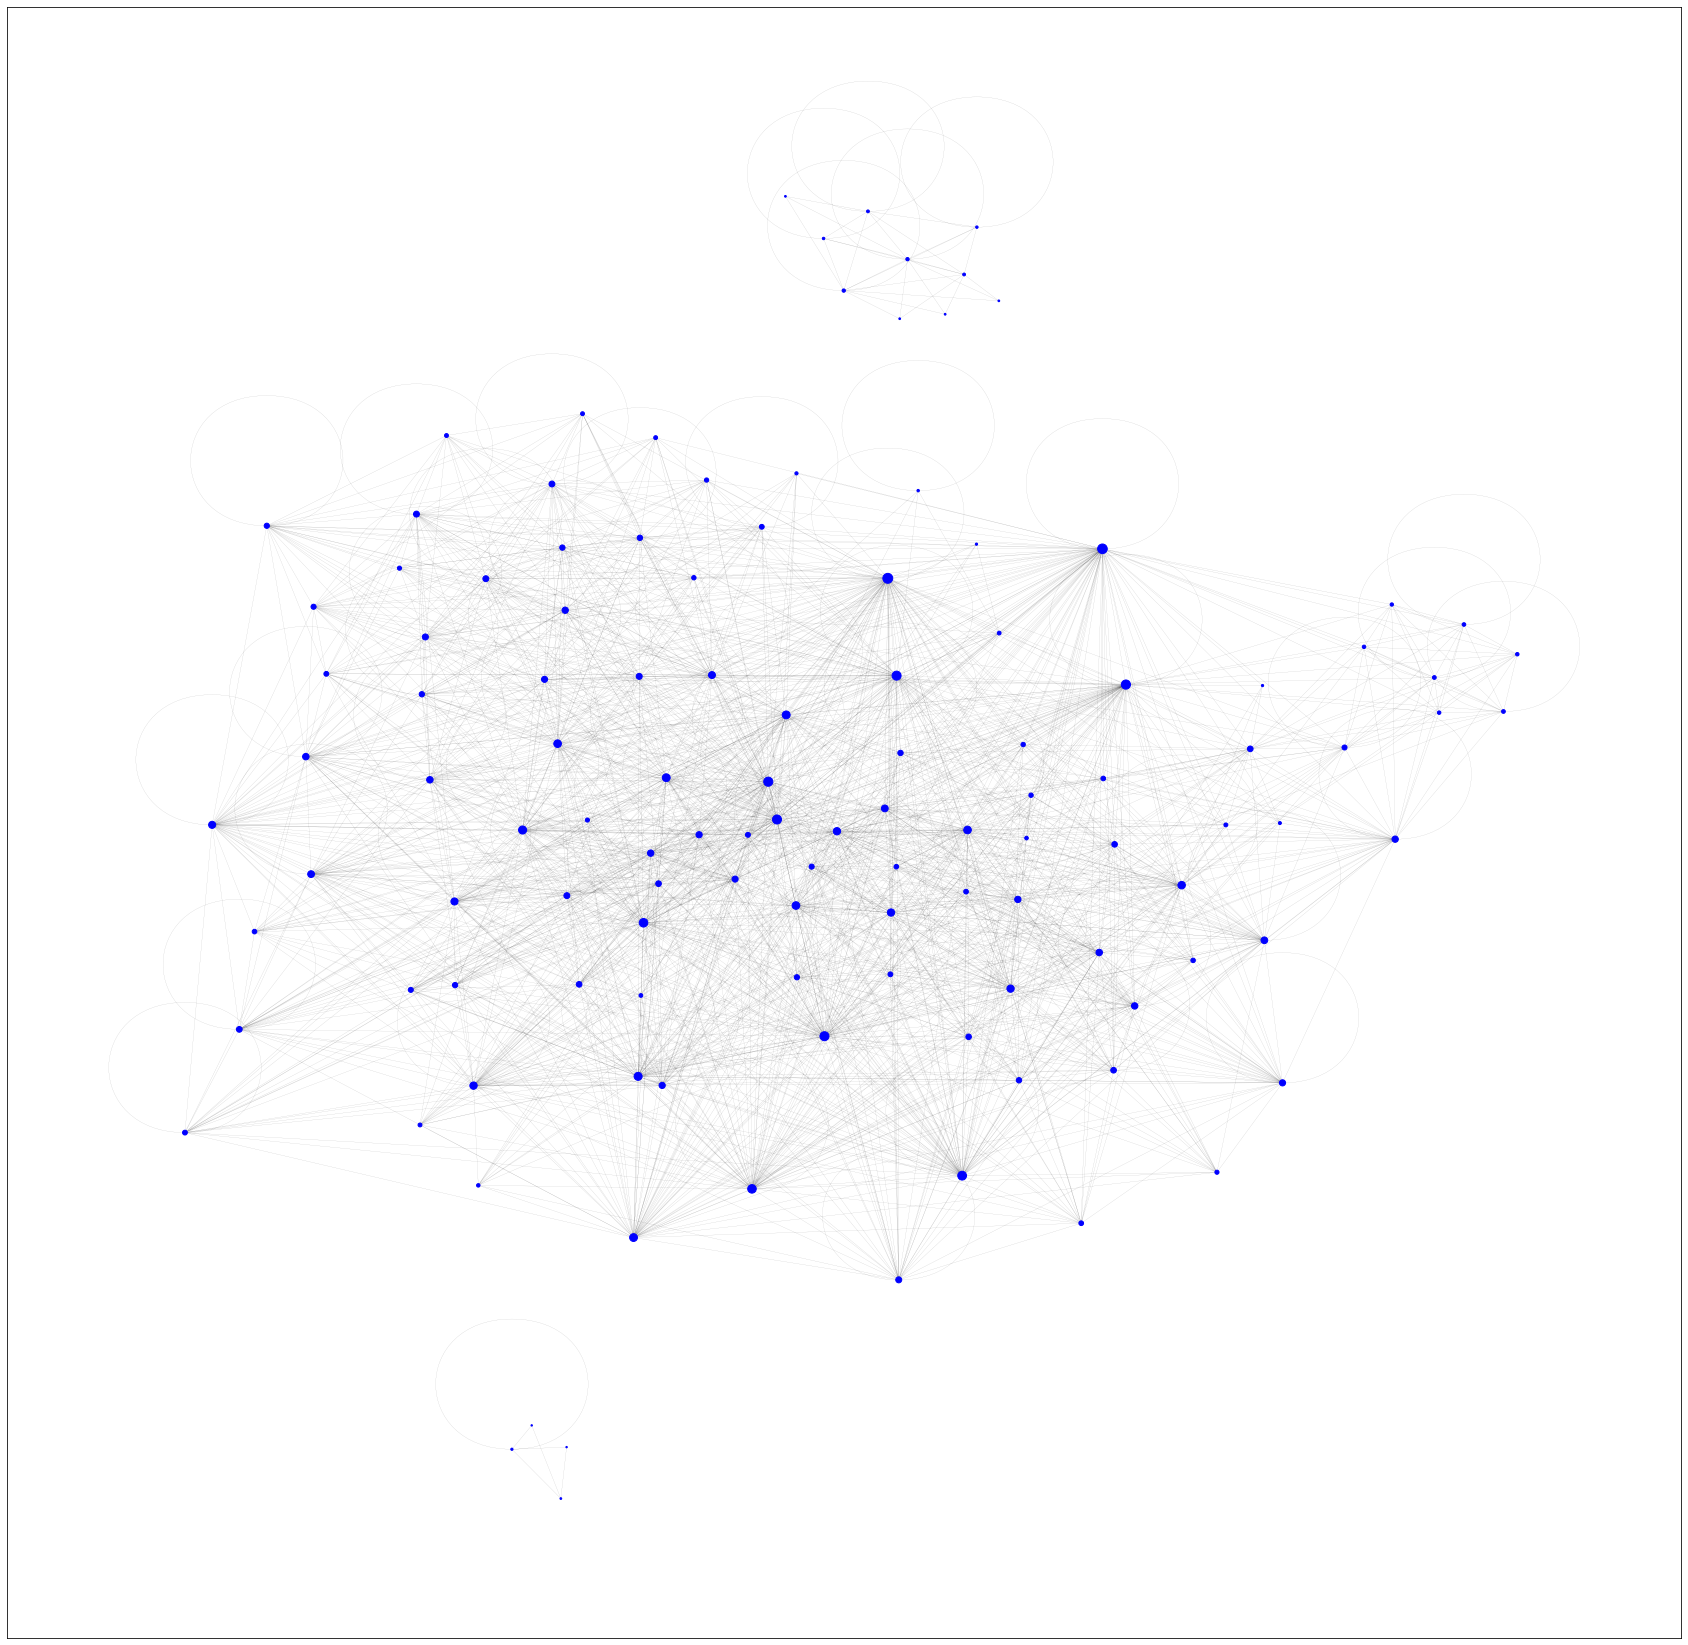

In [45]:
forceatlas = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=0.5,
                        adjustSizes=False,
                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.,
                        # Tuning
                        scalingRatio=20,
                        strongGravityMode=False,
                        gravity=200.0,
                        # Log
                        verbose=True)

positions = forceatlas.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
nx.draw_networkx_nodes(G, positions, node_size=degrees, node_color='blue', label=[''])
nx.draw_networkx_edges(G, positions, edge_color='black', alpha=0.5, width=0.1, arrowstyle="-")
plt.rcParams["figure.figsize"] = [30,30]
#plt.axis('off')
plt.show()

In [33]:
degree_distribution = sorted((d for n, d in G.degree), reverse=True)
degree_dist = dict([(degree[0], len(list(degree[1]))) for degree in itertools.groupby(degree_distribution)])

In [36]:
#We can see a list of all the podcasts and their degrees.
print(sorted(G.degree, key=lambda x: x[1], reverse=True))

[('The Learning Leader Show With Ryan Hawk', 98), ('Legendary Life | Transform Your Body, Upgrade Your Health & Live Your Best Life', 93), ('Five Minutes With Dad with Pavlos, Angela, and Nick Pavlidis', 84), ('Mindfulness Mode', 83), ('Discover Your Talent–Do What You Love | Build a Career of Success, Satisfaction and Freedom', 81), ('Leveling Up with Eric Siu', 81), ('Rental Income Podcast With Dan Lane', 81), ('ADHD reWired', 77), ('Interactive Body Balance with Mike Daciuk', 73), ('Confessions of a Terrible Husband with Nick Pavlidis', 73), ('The Kelly Roach Show', 65), ('Wisdom-Trek ©', 64), ('Best Real Estate Investing Advice Ever', 62), ('Everyday MBA', 61), ('Undone Redone', 61), ('Women Taking the Lead with Jodi Flynn', 58), ('The Busy Creator Podcast with Prescott Perez-Fox', 58), ("Old Dawg's REI Network with Bill Manassero", 58), ('People Behind the Science Podcast - Stories from Scientists about Science, Life, Research, and Scien...', 56), ('The Affluent Entrepreneur Show'

In [37]:
nx.common_neighbors([])

In [50]:
len(unique_data)

9135